<a href="https://colab.research.google.com/github/vijaykarthiksk11/Brain-Tumor-Classification/blob/main/Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed") # Changed to relative path
TRAIN_ZIP = "/content/test-20251030T072323Z-1-001.zip"
VALID_ZIP = "/content/valid-20251030T072326Z-1-001.zip"
TEST_ZIP  = "/content/test-20251030T072323Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting /content/test-20251030T072323Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Extracting /content/valid-20251030T072326Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251030T072323Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/test
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/test
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/test -> 4 class folders
Classes: ['meningioma', 'pituitary', 'glioma', 'no_tumor']


In [ ]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...


NotFoundError: Could not find directory data_extracted_fixed/train/train

In [ ]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [ ]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Training models...

Training CustomCNN ...
Epoch 1/20


✅ Evaluating models...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1058  Recall=0.3252  F1=0.1596
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



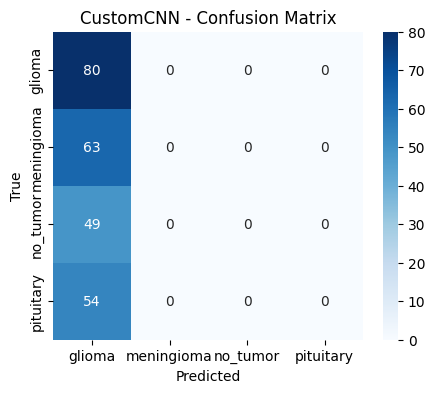


📊 ResNet50 Results:
Accuracy=0.4431  Precision=0.5224  Recall=0.4431  F1=0.3159
              precision    recall  f1-score   support

      glioma       0.39      1.00      0.56        80
  meningioma       1.00      0.02      0.03        63
    no_tumor       0.70      0.57      0.63        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.44       246
   macro avg       0.52      0.40      0.31       246
weighted avg       0.52      0.44      0.32       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

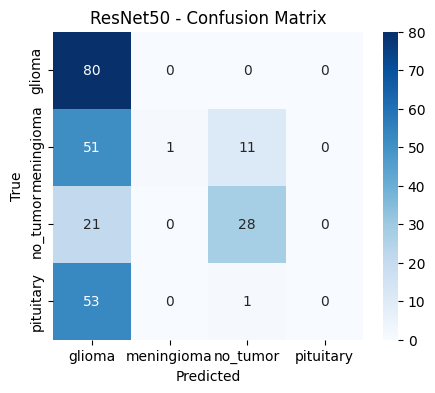


📊 MobileNetV2 Results:
Accuracy=0.6789  Precision=0.7456  Recall=0.6789  F1=0.6777
              precision    recall  f1-score   support

      glioma       0.88      0.70      0.78        80
  meningioma       0.67      0.41      0.51        63
    no_tumor       0.91      0.63      0.75        49
   pituitary       0.50      1.00      0.66        54

    accuracy                           0.68       246
   macro avg       0.74      0.69      0.67       246
weighted avg       0.75      0.68      0.68       246



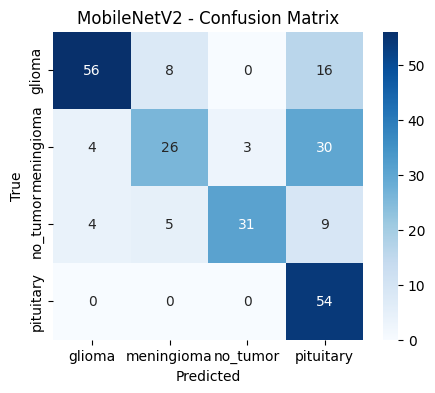


📊 InceptionV3 Results:
Accuracy=0.6789  Precision=0.6966  Recall=0.6789  F1=0.6599
              precision    recall  f1-score   support

      glioma       0.77      0.78      0.77        80
  meningioma       0.67      0.32      0.43        63
    no_tumor       0.77      0.67      0.72        49
   pituitary       0.57      0.96      0.71        54

    accuracy                           0.68       246
   macro avg       0.69      0.68      0.66       246
weighted avg       0.70      0.68      0.66       246



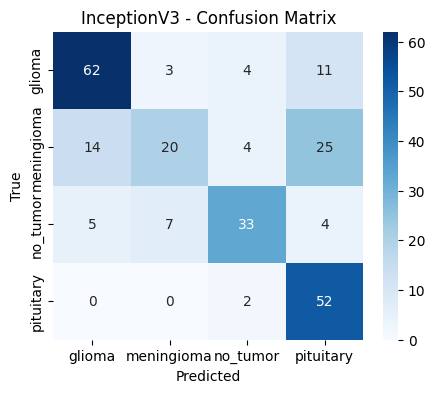

In [ ]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
2  MobileNetV2  0.678862   0.745645  0.678862  0.677729
3  InceptionV3  0.678862   0.696589  0.678862  0.659876
1     ResNet50  0.443089   0.522437  0.443089  0.315904
0    CustomCNN  0.325203   0.105757  0.325203  0.159609


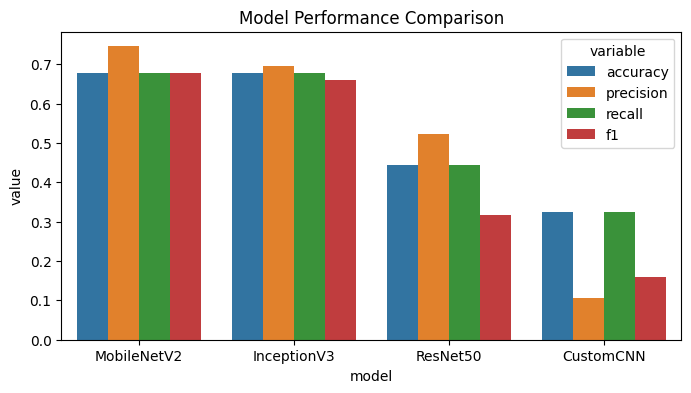


🏆 Best Performing Model: MobileNetV2


In [ ]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [ ]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/MobileNetV2_best.pkl
